In [1]:
import torch
import torch.utils.data as data

import numpy as np

In [2]:
from torch import nn, optim as opts
from plasma import blocks
from plasma.training import Trainer, metrics, callbacks
from tensorflow.keras import datasets as dts

In [3]:
(x_train, y_train), (x_test, y_test) = dts.mnist.load_data()

In [4]:
train = data.TensorDataset(torch.tensor(x_train[:, None, ...] / 127.5 - 1, dtype=torch.float), torch.tensor(y_train, dtype=torch.float))
test = data.TensorDataset(torch.tensor(x_test[:, None, ...] / 127.5 - 1, dtype=torch.float), torch.tensor(y_test, dtype=torch.float)) 

In [5]:
model = nn.Sequential(*[
    blocks.ConvBlock(1, 64, kernel_size=1, padding=0),
    blocks.ConvBlock(64, 128, stride=2),
    blocks.ConvBlock(128, 256, stride=2),
    blocks.commons.GlobalAverage(),
    nn.Linear(256, 10),
    nn.Softmax(dim=-1)
])

model.cuda(0)

Sequential(
  (0): ConvBlock(
    (transformer): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (normalizer): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activator): ReLU()
  )
  (1): ConvBlock(
    (transformer): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (normalizer): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activator): ReLU()
  )
  (2): ConvBlock(
    (transformer): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (normalizer): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activator): ReLU()
  )
  (3): GlobalAverage(axes=[2, 3], keepdims=False)
  (4): Linear(in_features=256, out_features=10, bias=True)
  (5): Softmax(dim=-1)
)

In [6]:
loss = nn.CrossEntropyLoss()

In [7]:
#trainer = Trainer(model, opts.Adam(model.parameters(), lr=1e-3), loss, metrics=[metrics.accuracy])
trainer = Trainer(model, opts.SGD(model.parameters(), lr=3.2), loss, metrics=[metrics.accuracy])

In [8]:
cbs = [
    callbacks.LrFinder(min_lr=1e-6, max_lr=20, epoch=3, iterations=len(train) // 32)
    #callbacks.CLR(1e-5, 3.2, iterations=len(train) // 32, reduce_lr_each_cycle=True)
    #callbacks.WarmRestart(1e-5, 1, factor=2)
]

In [9]:
trainer.fit(train, test, epochs=3, callbacks=cbs)

epoch: 1/3



epoch: 2/3



epoch: 3/3


No handles with labels found to put in legend.


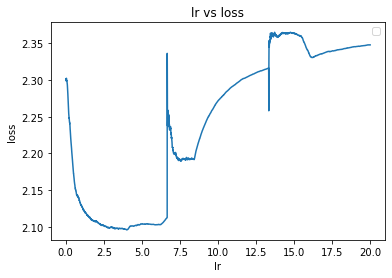

In [11]:
cbs[0].plot_data()